In [133]:
import os
import glob
import pandas as pd
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy
from tensorflow.keras import layers
import warnings
warnings.filterwarnings("ignore") # Ignore All Warnings

### Label Encoding

In [102]:
cwd = os.getcwd()
print("Current working directory:", cwd)

Current working directory: C:\Users\DELL\Desktop\Furkan\BLG_513E_Project_Final\CNN


In [103]:
drc_empty = cwd + '/**/Empty/*.jpg'
empty_files = glob.glob(drc_empty, recursive=True)
len(empty_files)

79888

In [104]:
y = ['Empty'] * int(len(empty_files))

In [105]:
drc_occupied = cwd + '/**/Occupied/*.jpg'
occupied_files = glob.glob(drc_occupied, recursive=True)
len(occupied_files)

67730

In [106]:
y = y + ( ['Occupied'] * int(len(occupied_files)))

In [107]:
file_names = empty_files + occupied_files  ## Contains the full path

### Creating the Dataframe

In [12]:
df = pd.DataFrame(data={'filename' : file_names , 'target': y})
df = shuffle(df)
df.index = range(df.shape[0])
df

,filename,target
0,C:\Users\DELL\Desktop\Furkan\BLG_513E_Project_...,Empty
1,C:\Users\DELL\Desktop\Furkan\BLG_513E_Project_...,Empty
2,C:\Users\DELL\Desktop\Furkan\BLG_513E_Project_...,Occupied
3,C:\Users\DELL\Desktop\Furkan\BLG_513E_Project_...,Empty
4,C:\Users\DELL\Desktop\Furkan\BLG_513E_Project_...,Empty
...,...,...
147613,C:\Users\DELL\Desktop\Furkan\BLG_513E_Project_...,Empty
147614,C:\Users\DELL\Desktop\Furkan\BLG_513E_Project_...,Occupied
147615,C:\Users\DELL\Desktop\Furkan\BLG_513E_Project_...,Empty
147616,C:\Users\DELL\Desktop\Furkan\BLG_513E_Project_...,Empty


### Creating Keras dataset

In [13]:
datagen = ImageDataGenerator(rescale=1/255., validation_split=0.2)

In [14]:
train_generator = datagen.flow_from_dataframe(dataframe=df, directory=None,
                                             x_col='filename',
                                             y_col='target',
                                             target_size=(64,64),
                                             class_mode='binary',
                                             batch_size=100,
                                             shuffle=True,
                                             subset='training',
                                             seed=7)

validation_generator = datagen.flow_from_dataframe(dataframe=df, directory=None,
                                             x_col='filename',
                                             y_col='target',
                                             target_size=(64,64),
                                             class_mode='binary',
                                             shuffle=False,
                                             batch_size=100,
                                             subset='validation',
                                             seed=7)

Found 118095 validated image filenames belonging to 2 classes.
Found 29523 validated image filenames belonging to 2 classes.


### Visulizing the Dataset

In [15]:
images , labels = train_generator[0]

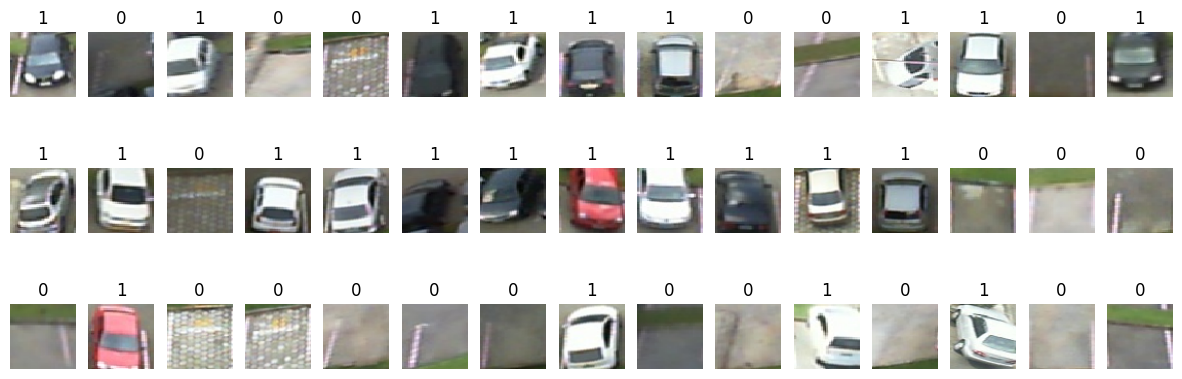

In [16]:
plt.figure(figsize=(15, 5))
for i in range(45):
    ax = plt.subplot(3, 15, i + 1)
    plt.imshow(images[i])
    plt.title(int(labels[i]))
    plt.axis("off")

### Data Augmentation ( no need to apply )

In [17]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

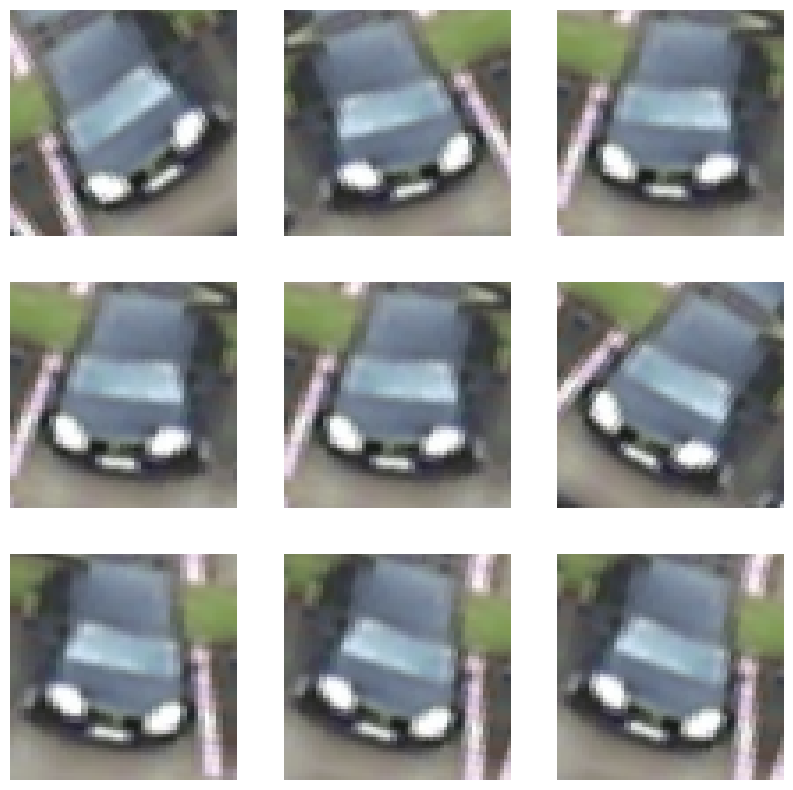

In [18]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_images = data_augmentation(images[0])
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images)
    plt.axis("off")

### CNN model

In [22]:
cnn = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64,64,3)),
    keras.layers.MaxPooling2D((2, 2)),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(2, activation='sigmoid')
])

In [23]:
cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training

In [24]:
cnn.fit(train_generator, validation_data = validation_generator, epochs=5)

Epoch 1/5
1181/1181 [==============================] - 259s 219ms/step - loss: 0.0287 - accuracy: 0.9918 - val_loss: 0.0092 - val_accuracy: 0.9988
Epoch 2/5
1181/1181 [==============================] - 230s 194ms/step - loss: 0.0114 - accuracy: 0.9980 - val_loss: 0.3076 - val_accuracy: 0.9141
Epoch 3/5
1181/1181 [==============================] - 240s 203ms/step - loss: 0.0167 - accuracy: 0.9961 - val_loss: 0.0082 - val_accuracy: 0.9988
Epoch 4/5
1181/1181 [==============================] - 249s 211ms/step - loss: 0.0080 - accuracy: 0.9987 - val_loss: 0.0077 - val_accuracy: 0.9989
Epoch 5/5
1181/1181 [==============================] - 235s 199ms/step - loss: 0.0079 - accuracy: 0.9986 - val_loss: 0.0089 - val_accuracy: 0.9989


In [134]:
cnn.save("mysavedmodel") # Saving the model

INFO:tensorflow:Assets written to: mysavedmodel\assets


INFO:tensorflow:Assets written to: mysavedmodel\assets


### Evaluation

In [25]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

In [26]:
cnn.evaluate(validation_generator,
steps=STEP_SIZE_VALID)

295/295 [==============================] - 16s 53ms/step - loss: 0.0089 - accuracy: 0.9989


[0.008930218406021595, 0.9989491701126099]

In [27]:
y_predicted = cnn.predict(validation_generator)

296/296 [==============================] - 17s 57ms/step


In [28]:
pred = [ numpy.argmax(i) for i in y_predicted]
pred[:10]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1]

### Confusion Matrix

In [32]:
cm = tf.math.confusion_matrix(labels = validation_generator.classes , predictions = pred)

Text(95.72222222222221, 0.5, 'Truth')

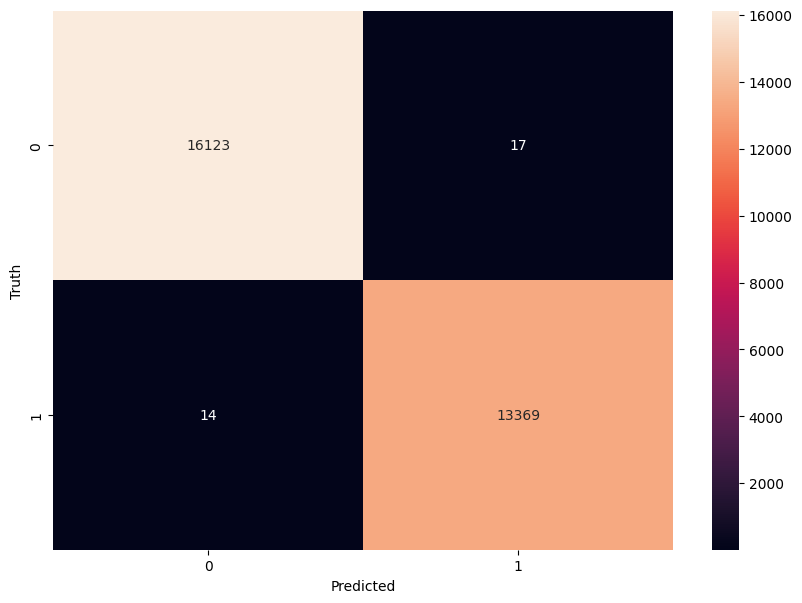

In [33]:
import seaborn as sn
plt.figure(figsize= (10,7))
sn.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Truth')

### What are the images machine predicted wrong ?

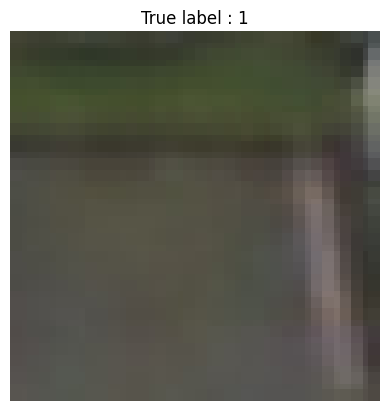

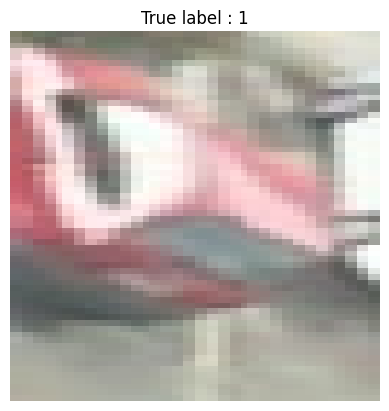

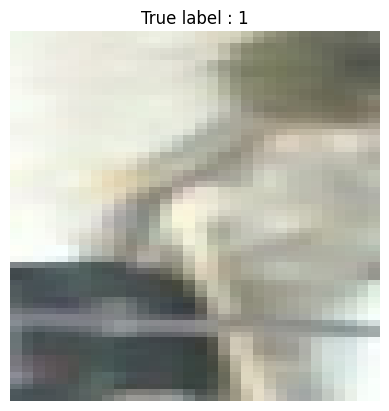

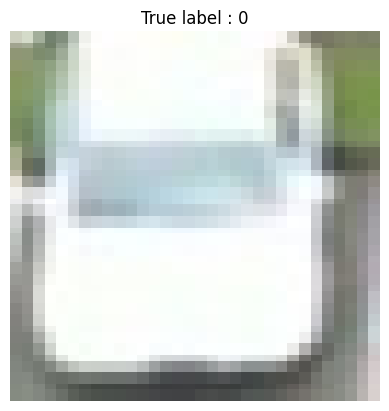

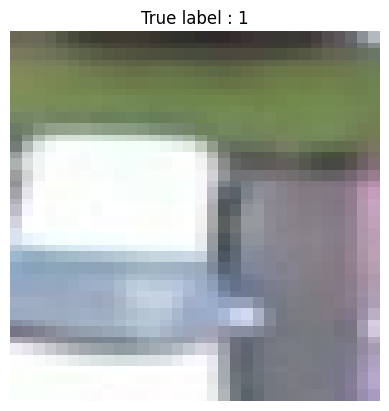

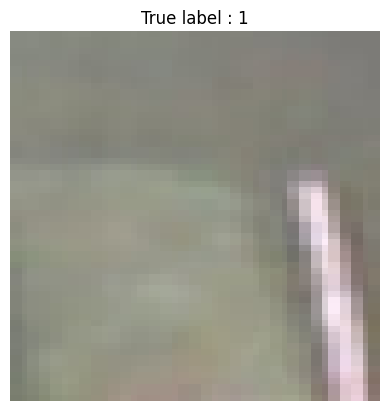

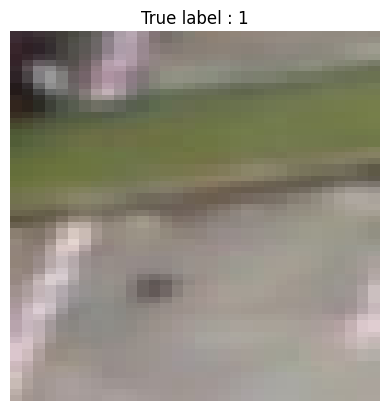

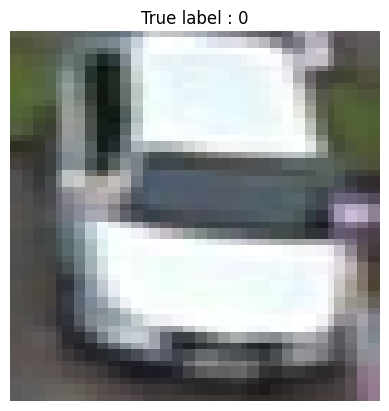

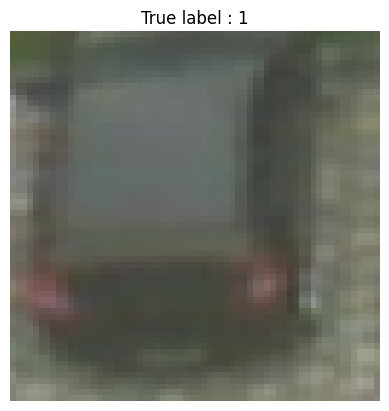

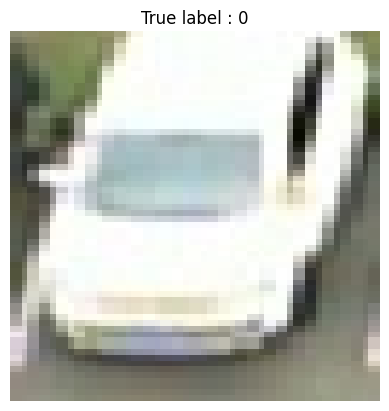

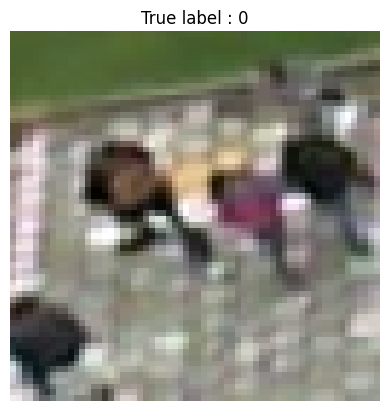

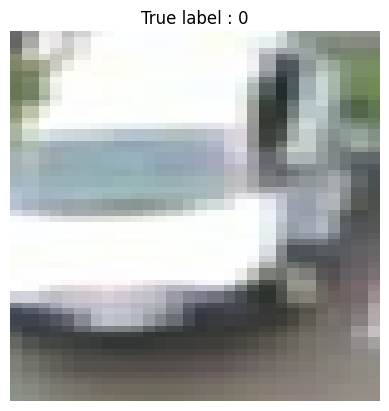

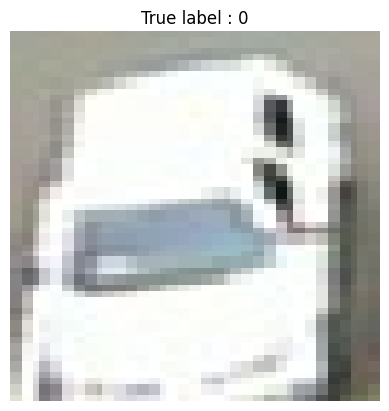

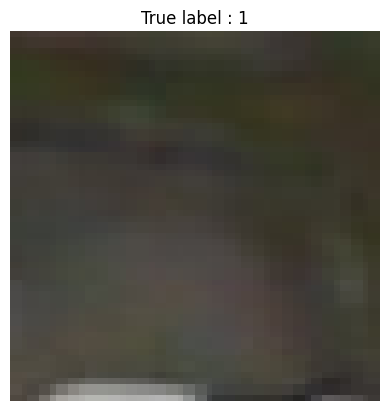

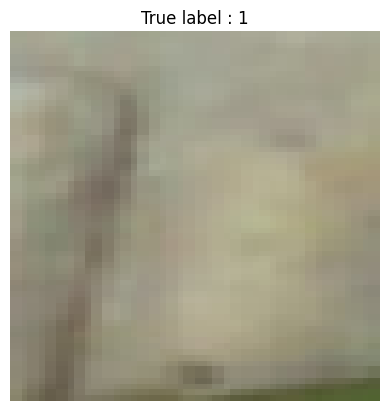

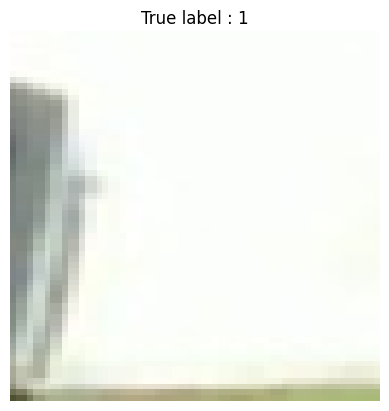

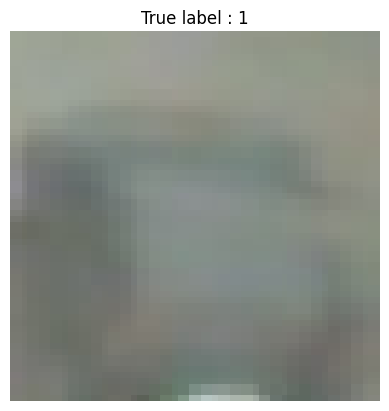

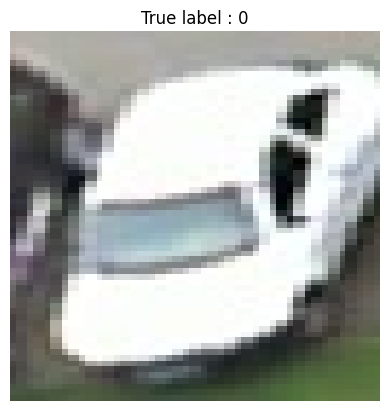

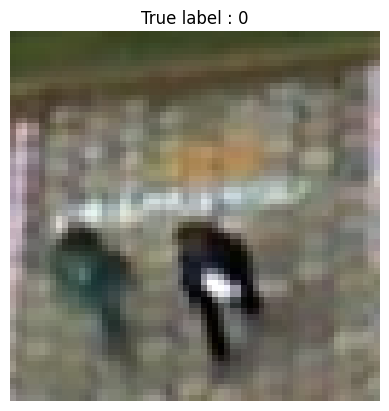

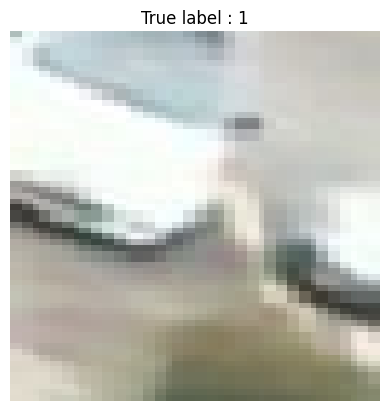

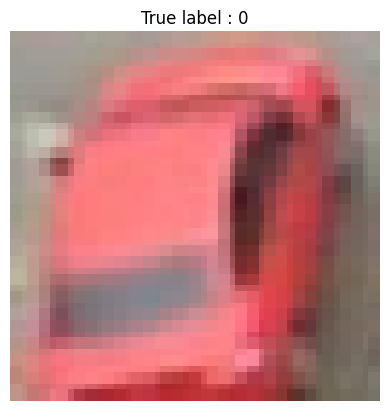

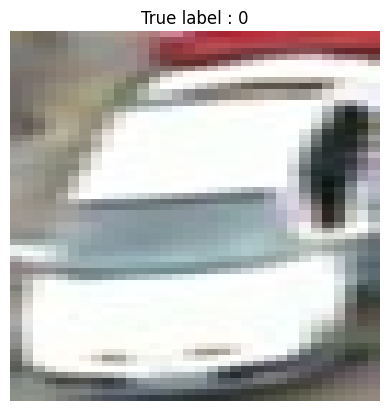

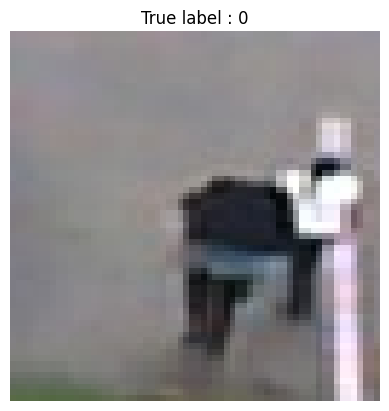

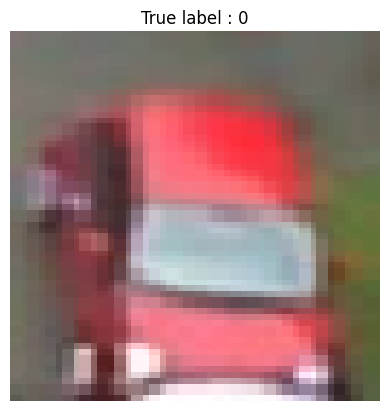

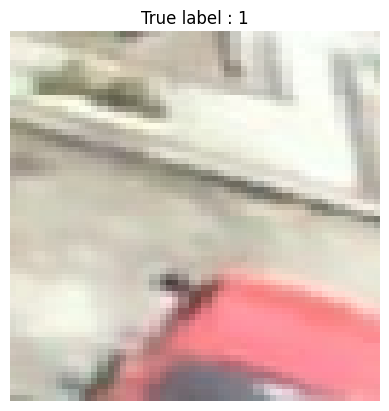

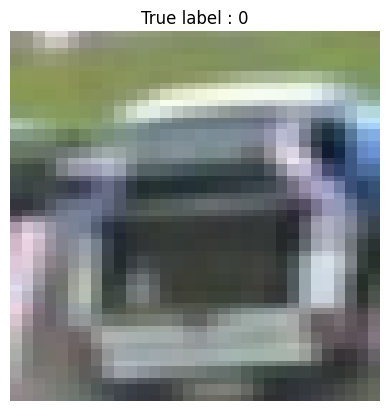

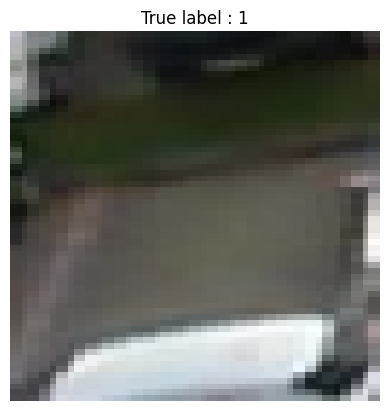

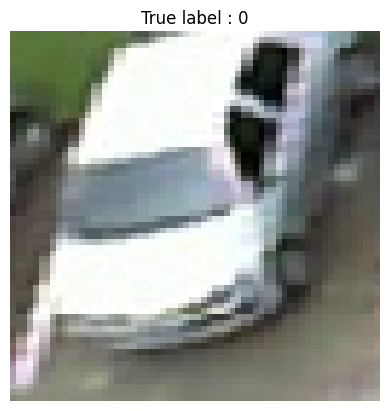

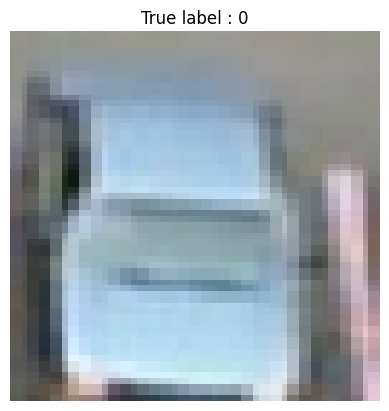

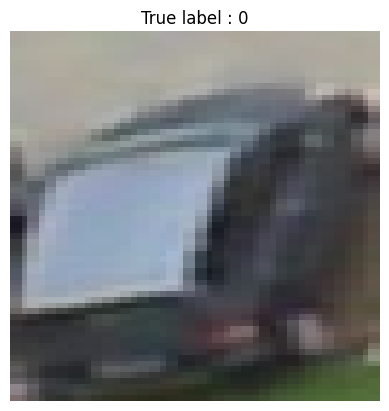

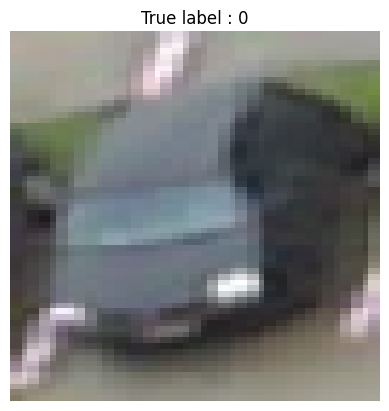

In [125]:
count = 0
for i in range(len(validation_generator.classes)):
    if i % 100 == 0:
        image , label = validation_generator[int(i / 100)]
    if validation_generator.classes[i] != pred[i]:
        plt.figure()
        plt.imshow(image[i%100])
        plt.title("True label : " + str(int(validation_generator.classes[i])))
        plt.axis("off")
        count = count + 1
    else:
        pass       

In [126]:
print("Out of", len(validation_generator.classes), "validation images" , count , "are predicted wrong")

Out of 29523 validation images 31 are predicted wrong


### Saving results to a .csv file

In [127]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in pred]

In [130]:
filenames=validation_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results.csv",index=False)